In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from math import ceil
from utils import *
from magnet_ops import *

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
class MNISTEncoder(object):
    def __init__(self, emb_dim, sess):
        self.emb_dim = emb_dim
        self.sess = sess
        
        self.inputs = tf.placeholder("float32", [None, 28*28])
        self.labels = tf.placeholder("bool", [None])
        
        self._build_model()

    def _build_model(self):
        # Convolutional encoder
        x_image = tf.reshape(self.inputs, [-1,28,28,1])

        self.W_conv1 = weight_variable([5, 5, 1, 32])
        self.b_conv1 = bias_variable([32])
        self.h_conv1 = tf.nn.relu(conv2d(x_image, self.W_conv1) + self.b_conv1)
        self.h_pool1 = max_pool_2x2(self.h_conv1)

        self.W_conv2 = weight_variable([5, 5, 32, 64])
        self.b_conv2 = bias_variable([64])

        self.h_conv2 = tf.nn.relu(conv2d(self.h_pool1, self.W_conv2) + self.b_conv2)
        self.h_pool2 = max_pool_2x2(self.h_conv2)

        self.W_fc1 = weight_variable([7 * 7 * 64, self.emb_dim])
        self.b_fc1 = bias_variable([self.emb_dim])

        h_pool2_flat = tf.reshape(self.h_pool2, [-1, 7*7*64])
        self.emb = tf.matmul(h_pool2_flat, self.W_fc1) + self.b_fc1

        # L2 normalize
        self.norm_emb = tf.nn.l2_normalize(self.emb, 1)

    def get_norm_embedding(self, batch):
        return self.sess.run(self.norm_emb, feed_dict={self.inputs: batch})        
        
    def get_embedding(self, batch):
        return self.sess.run(self.emb, feed_dict={self.inputs: batch})

In [3]:
from sklearn.cluster import KMeans

class ClusterBatchBuilder(object):
    def __init__(self, labels, k, m, d):
        
        self.num_classes = np.unique(labels).shape[0]
        self.labels = labels

        self.k = k
        self.m = m
        self.d = d

        self.centroids = None
        self.assignments = np.zeros_like(labels, int)
        self.cluster_assignments = {}
        self.cluster_classes = np.repeat(range(self.num_classes), k)
        self.example_losses = None
        self.cluster_losses = None

    
    def update_clusters(self, rep_data, max_iter=20):
        """
        Given an array of representations for the entire training set,
        recompute clusters and store example cluster assignments in a
        quickly sampleable form.
        """
        # Lazily allocate array for centroids
        if self.centroids is None:
            self.centroids = np.zeros([self.num_classes * self.k, rep_data.shape[1]])
        
        for c in range(self.num_classes):

            class_mask = self.labels == c
            class_examples = rep_data[class_mask]
            kmeans = KMeans(n_clusters=self.k, init='k-means++', n_init=1, max_iter=max_iter)
            kmeans.fit(class_examples)

            # Save cluster centroids for finding impostor clusters
            start = self.get_cluster_ind(c, 0)
            stop = self.get_cluster_ind(c, self.k)
            self.centroids[start:stop] = kmeans.cluster_centers_

            # Update assignments with new global cluster indexes
            self.assignments[class_mask] = self.get_cluster_ind(c, kmeans.predict(class_examples))
            
        # Construct a map from cluster to example indexes for fast batch creation
        for cluster in range(self.k * self.num_classes):
            cluster_mask = self.assignments == cluster
            self.cluster_assignments[cluster] = np.flatnonzero(cluster_mask)

        
    def update_losses(self, indexes, losses):
        """
        Given a list of examples indexes and corresponding losses
        store the new losses and update corresponding cluster losses.
        """
        # Lazily allocate structures for losses
        if self.example_losses is None:
            self.example_losses = np.zeros_like(self.labels, float)
            self.cluster_losses = np.zeros([self.k * self.num_classes], float)

        # Update example losses
        self.example_losses[np.array(indexes)] = losses
        
        # Find affected clusters and update the corresponding cluster losses
        clusters = np.unique(self.assignments[indexes])
        for cluster in clusters:
            cluster_example_losses = self.example_losses[self.assignments == cluster]
            self.cluster_losses[cluster] = np.mean(cluster_example_losses)

        
    def gen_batch(self):
        """
        Sample a batch by first sampling a seed cluster proportionally to
        the mean loss of the clusters, then finding nearest neighbor
        "impostor" clusters, then sampling d examples uniformly from each cluster.
        
        The generated batch will consist of m clusters each with d consecutive
        examples.
        """
        
        # Sample seed cluster proportionally to cluster losses if available
        if self.cluster_losses is not None:
            p = self.cluster_losses / np.sum(self.cluster_losses)
            seed_cluster = np.random.choice(self.num_classes * self.k, p=p)
            print p
        else:
            seed_cluster = np.random.choice(self.num_classes * self.k)

        # Get imposter clusters by ranking centroids by distance
        sq_dists = ((self.centroids[seed_cluster] - self.centroids) ** 2).sum(axis=1)
        
        # Assure only clusters of different class from seed are chosen
        sq_dists[self.get_class_ind(seed_cluster) == self.cluster_classes] = np.inf
        
        # Get top impostor clusters and add seed
        clusters = np.argpartition(sq_dists, self.m-1)[:self.m-1]
        clusters = np.concatenate([[seed_cluster], clusters])
        
        # Sample examples uniformly from cluster
        batch_indexes = np.empty([self.m * self.d], int)
        for i, c in enumerate(clusters):
            x = np.random.choice(self.cluster_assignments[c], self.d, replace=False)
            start = i * self.d
            stop = start + self.d
            batch_indexes[start:stop] = x

        # Translate class indexes to index for classes within the batch
        class_inds = self.get_class_ind(clusters)
        batch_class_inds = []
        inds_map = {}
        class_count = 0
        for c in class_inds:
            if c not in inds_map:
                inds_map[c] = class_count
                class_count += 1
            batch_class_inds.append(inds_map[c])

        return batch_indexes, np.repeat(batch_class_inds, self.d)

    
    def get_cluster_ind(self, c, i):
        """
        Given a class index and a cluster index within the class
        return the global cluster index
        """
        return c * self.k + i
    
    def get_class_ind(self, c):
        """
        Given a cluster index return the class index.
        """
        return c / self.k
    

# rep = np.random.random([mnist.train.images.shape[0], 8])
# batch_builder = ClusterBatchBuilder(mnist.train.labels, 5, 12, 4)
# batch_builder.update_clusters(rep)
# batch_builder.update_losses(range(mnist.train.labels.shape[0]), np.random.random([mnist.train.labels.shape[0]]))
# example_inds, class_inds = batch_builder.gen_batch()
# print example_inds, class_inds


In [5]:
# Define magnet loss parameters
m = 8
d = 8
k = 3
alpha = 1.0
batch_size = m * d

# Define training data
X = mnist.train.images
y = mnist.train.labels

# Define model and training parameters
epoch_steps = int(ceil(float(X.shape[0]) / batch_size)) 
emb_dim = 2
num_steps = epoch_steps * 10
cluster_refresh_interval = epoch_steps



sess = tf.InteractiveSession()

# Model
with tf.variable_scope('model'):
    model = MNISTEncoder(emb_dim, sess)

# Loss
with tf.variable_scope('magnet_loss'):
    class_inds = tf.placeholder(tf.int32, [m*d])
    train_loss, losses = minibatch_magnet_loss(model.emb, class_inds, m, d, alpha)

train_op = tf.train.AdamOptimizer(1e-4).minimize(train_loss)

sess.run(tf.initialize_all_variables())



def compute_reps(extract_fn, X, chunk_size):
    chunks = int(ceil(float(X.shape[0]) / chunk_size))
    reps = []
    for i in range(chunks):
        start = i * chunk_size
        stop = start + chunk_size
        chunk_reps = extract_fn(X[start:stop])
        reps.append(chunk_reps)
    return np.vstack(reps)

# Get initial embedding
extract = lambda x: sess.run(model.emb, feed_dict={model.inputs: x})
initial_reps = compute_reps(extract, X, 400)


# Create batcher
batch_builder = ClusterBatchBuilder(mnist.train.labels, k, m, d)
batch_builder.update_clusters(initial_reps)

for i in range(num_steps):
    
    batch_example_inds, batch_class_inds = batch_builder.gen_batch()
    feed_dict = {model.inputs: X[batch_example_inds], class_inds: batch_class_inds}
    _, batch_loss = sess.run([train_op, train_loss], feed_dict=feed_dict)
    
    if not i % 100:
        print i, batch_loss
    
    if not i % cluster_refresh_interval:
        print 'Refreshing clusters'
        reps = compute_reps(extract, X, 400)
        batch_builder.update_clusters(reps)
        
final_reps = compute_reps(extract, X, 400)
    
sess.close()
tf.reset_default_graph()

0 2.4325
Refreshing clusters
100 1.18415
200 1.1136
300 0.736997
400 0.569779
500 0.93512
600 0.797506
700 0.863787
800 0.682133
Refreshing clusters
900 0.948899
1000 0.259476
1100 0.139393
1200 0.477659
1300 1.11976
1400 0.296286
1500 0.604563
1600 0.660448
1700 0.601884
Refreshing clusters
1800 0.649322
1900 0.333496
2000 0.487782
2100 0.648669
2200 0.384135
2300 0.232068
2400 0.467106
2500 0.547874
Refreshing clusters
2600 0.338396
2700 0.373904
2800 0.83355
2900 0.192128
3000 0.549635
3100 0.630218
3200 0.70895
3300 0.507268
3400 0.136957
Refreshing clusters
3500 0.278441
3600 0.489563
3700 0.0344034
3800 0.676357
3900 0.0755105
4000 0.14216
4100 0.464534
4200 0.364041
4300 0.361897
Refreshing clusters
4400 0.613005
4500 0.633314
4600 0.823576
4700 0.57141
4800 0.265734
4900 0.305901
5000 0.301941
5100 0.272122
Refreshing clusters
5200 0.198294
5300 0.175433
5400 0.0927203
5500 0.715985
5600 0.0988182
5700 0.0953577
5800 0.461687
5900 0.649077
6000 0.179982
Refreshing clusters
6100

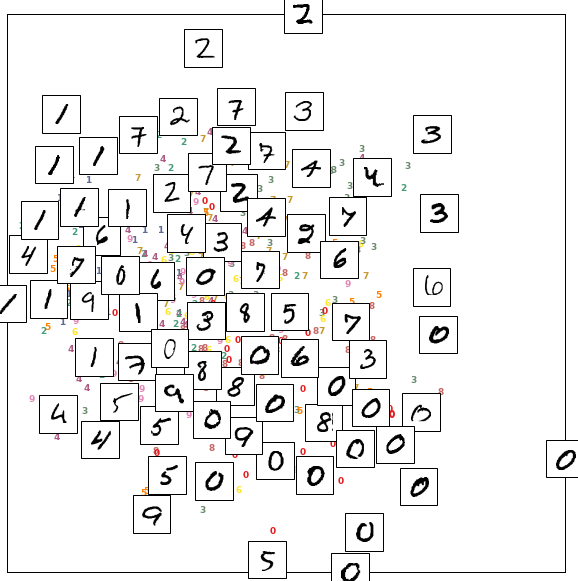

In [6]:
num_plot = 500
imgs = mnist.train.images[:num_plot]
imgs = np.reshape(imgs, [num_plot, 28, 28])
plot_embedding(initial_reps[:num_plot], mnist.train.labels[:num_plot], imgs)

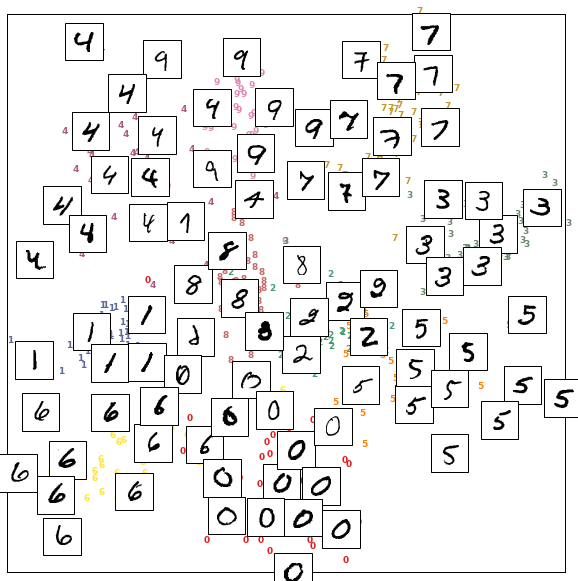

In [7]:
num_plot = 500
imgs = mnist.train.images[:num_plot]
imgs = np.reshape(imgs, [num_plot, 28, 28])
plot_embedding(final_reps[:num_plot], mnist.train.labels[:num_plot], imgs)